In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
drive_path = "/content/drive/MyDrive/Colab Notebooks/BoolQ_Project"
!ls "/content/drive/MyDrive/Colab Notebooks/BoolQ_Project"

boolq_finetuned_bert_best	      pubmedqa_eval_metrics.txt
boolq_finetuned_bert_best_current     pubmedqa_model_comparison.csv
boolq_finetuned_distilbert_best       pubmedqa_passages_10k.txt
boolq_finetuned_roberta_best	      pubmedqa_passages_full.txt
boolq_test_predictions_bert.csv       pubmedqa_test_metrics_10k.txt
boolq_test_predictions.csv	      pubmedqa_test_predictions_10k.csv
boolq_test_predictions_epoch3.csv     pubmedqa_train.csv
boolq_test_predictions_roberta.csv    roberta_pubmedqa_baseline
dev_df_clean.csv		      roberta_pubmedqa_finetuned_10k
PubMedQA			      roberta_pubmedqa_finetuned_15k
pubmedqa_dev.csv		      roberta_pubmedqa_finetuned_6k
pubmedqa_dev_preds_boolq.csv	      roberta_tapt_pubmedqa
pubmedqa_dev_preds_tapt6.csv	      roberta_tapt_pubmedqa_10k
pubmedqa_dev_with_predictions.csv     roberta_tapt_pubmedqa_15k
pubmedqa_eval_metrics_boolq_only.txt  test_df_clean.csv
pubmedqa_eval_metrics_tapt6.txt       train_df_clean.csv


In [ ]:
# ✅ Step 3: Load Dev CSV and Pretrained Model
dev_df = pd.read_csv(f"{drive_path}/pubmedqa_dev.csv")

model_path = f"{drive_path}/roberta_pubmedqa_finetuned_15k"
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model.to(device)
print("🚀 Model and tokenizer loaded.")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/BoolQ_Project/roberta_pubmedqa_finetuned_15k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Model and tokenizer loaded.


In [ ]:
# ✅ Step 4: Create Dataset and Dataloader
class PubMedQADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        question = self.data.iloc[index]['question']
        passage = self.data.iloc[index]['passage']
        label = torch.tensor(self.data.iloc[index]['answer'], dtype=torch.long)

        inputs = self.tokenizer(
            question, passage,
            truncation=True, padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item['labels'] = label
        return item

dev_dataset = PubMedQADataset(dev_df, tokenizer)
dev_loader = DataLoader(dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=8)


In [ ]:
# ✅ Step 5: Evaluate on Dev Set
model.eval()
dev_preds, dev_labels = [], []

with torch.no_grad():
    for batch in tqdm(dev_loader, desc="Evaluating TAPT-15K"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        dev_preds.extend(preds.cpu().numpy())
        dev_labels.extend(labels.cpu().numpy())

acc = accuracy_score(dev_labels, dev_preds)
f1 = f1_score(dev_labels, dev_preds)

print(f"\n✅ Final Evaluation of TAPT-15K")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


Evaluating TAPT-15K:   0%|          | 0/150 [00:00<?, ?it/s]<ipython-input-10-231a00f0d6f1>:14: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label = torch.tensor(self.data.iloc[index]['answer'], dtype=torch.long)
Evaluating TAPT-15K:   7%|▋         | 10/150 [00:03<00:34,  4.06it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating TAPT-15K:   7%|▋         | 11/150 [00:03<00:34,  4.06it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation st


✅ Final Evaluation of TAPT-15K
Accuracy: 0.8483
F1 Score: 0.9179


,Model,Accuracy,F1 Score
0,BoolQ-only RoBERTa,0.8442,0.9131
1,TAPT-6K RoBERTa,0.8483,0.9179
2,TAPT-10K RoBERTa,0.8983,0.9408
3,TAPT-15K RoBERTa,0.8483,0.9179


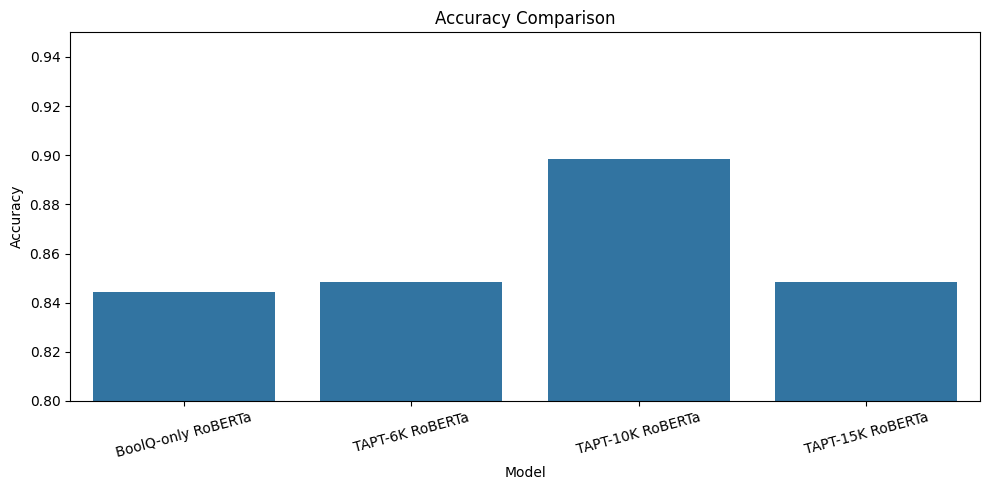

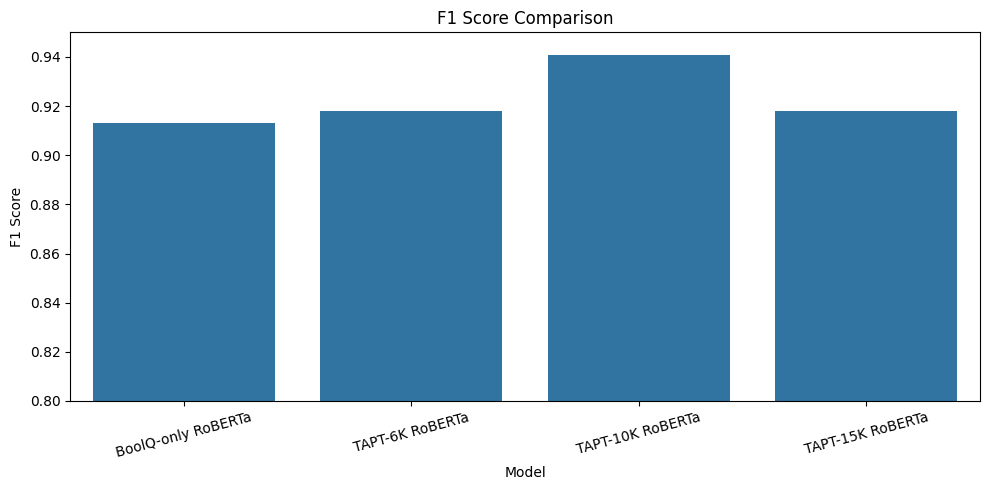

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Data
results = {
    "Model": [
        "BoolQ-only RoBERTa",
        "TAPT-6K RoBERTa",
        "TAPT-10K RoBERTa",
        "TAPT-15K RoBERTa"
    ],
    "Accuracy": [0.8442, 0.8483, 0.8983, 0.8483],
    "F1 Score": [0.9131, 0.9179, 0.9408, 0.9179]
}

df = pd.DataFrame(results)

# Display table
display(df)

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Accuracy", data=df)
plt.title("Accuracy Comparison")
plt.ylim(0.80, 0.95)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="F1 Score", data=df)
plt.title("F1 Score Comparison")
plt.ylim(0.80, 0.95)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# All evaluation results
data = {
    "Model": [
        "BERT (BoolQ)",
        "DistilBERT (BoolQ)",
        "RoBERTa (BoolQ)",
        "RoBERTa + TAPT-6K",
        "RoBERTa + TAPT-10K",
        "RoBERTa + TAPT-15K"
    ],
    "Accuracy": [
        0.7153,
        0.7073,
        0.7835,
        0.8483,
        0.8983,
        0.8483  # final eval score after fine-tuning TAPT-15K
    ],
    "F1 Score": [
        0.7893,
        0.7735,
        0.8261,
        0.9179,
        0.9408,
        0.9179
    ]
}

df = pd.DataFrame(data)
df


,Model,Accuracy,F1 Score
0,BERT (BoolQ),0.7153,0.7893
1,DistilBERT (BoolQ),0.7073,0.7735
2,RoBERTa (BoolQ),0.7835,0.8261
3,RoBERTa + TAPT-6K,0.8483,0.9179
4,RoBERTa + TAPT-10K,0.8983,0.9408
5,RoBERTa + TAPT-15K,0.8483,0.9179


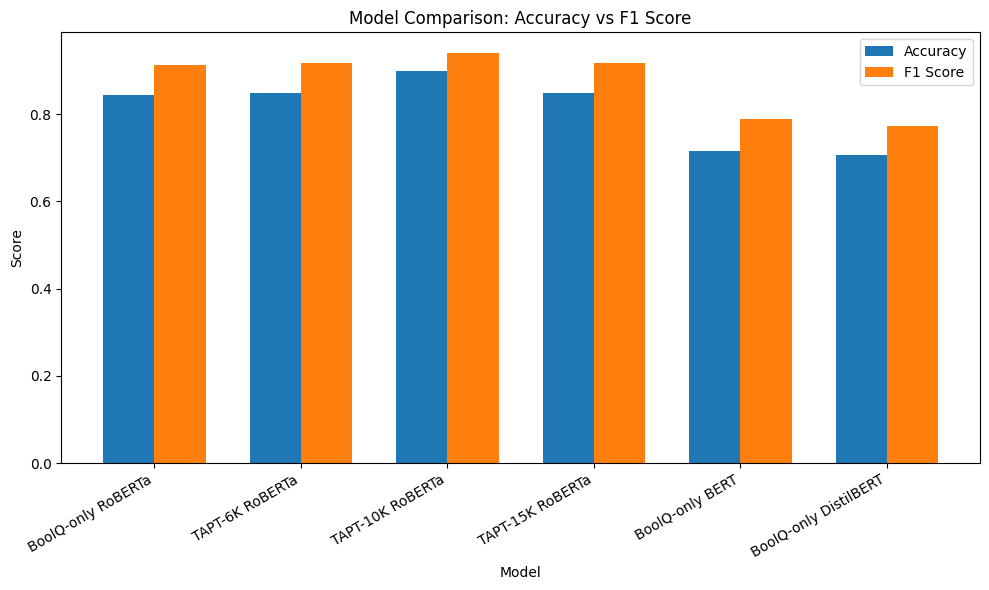

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Updated results including BERT and DistilBERT
results_data = {
    "Model": [
        "BoolQ-only RoBERTa",
        "TAPT-6K RoBERTa",
        "TAPT-10K RoBERTa",
        "TAPT-15K RoBERTa",
        "BoolQ-only BERT",
        "BoolQ-only DistilBERT"
    ],
    "Accuracy": [
        0.8442,
        0.8483,
        0.8983,
        0.8483,
        0.7153,
        0.7073
    ],
    "F1 Score": [
        0.9131,
        0.9179,
        0.9408,
        0.9179,
        0.7893,
        0.7735
    ]
}

results_df = pd.DataFrame(results_data)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(results_df))
bar_width = 0.35

ax.bar(x, results_df["Accuracy"], width=bar_width, label='Accuracy')
ax.bar([i + bar_width for i in x], results_df["F1 Score"], width=bar_width, label='F1 Score')

ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("Model Comparison: Accuracy vs F1 Score")
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(results_df["Model"], rotation=30, ha="right")
ax.legend()
plt.tight_layout()



In [ ]:
# Save TAPT-15K evaluation results
save_path = "/content/drive/MyDrive/Colab Notebooks/BoolQ_Project/pubmedqa_eval_metrics_tapt15.txt"

with open(save_path, 'w') as f:
    f.write("✅ Final Evaluation of TAPT-15K\n")
    f.write(f"Accuracy: {acc:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")

# Copy to your Google Drive
!cp {save_path} "{drive_path}/"
print(f"✅ TAPT-15K metrics saved to: {drive_path}/pubmedqa_eval_metrics_tapt15.txt")


cp: cannot stat '/content/drive/MyDrive/Colab': No such file or directory
cp: cannot stat 'Notebooks/BoolQ_Project/pubmedqa_eval_metrics_tapt15.txt': No such file or directory
✅ TAPT-15K metrics saved to: /content/drive/MyDrive/Colab Notebooks/BoolQ_Project/pubmedqa_eval_metrics_tapt15.txt


In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from torch.utils.data import DataLoader, Dataset, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import pandas as pd
import torch



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load your dev set
path_to_dev_csv = "/content/drive/My Drive/Colab Notebooks/BoolQ_Project/pubmedqa_dev.csv"
dev_df = pd.read_csv(path_to_dev_csv)
dev_df['answer'] = dev_df['answer'].astype(int)

In [ ]:
# Dataset class for PubMedQA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PubMedQADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        question = self.data.iloc[index]['question']
        passage = self.data.iloc[index]['passage']
        inputs = self.tokenizer(
            question,
            passage,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item['labels'] = torch.tensor(self.data.iloc[index]['answer'], dtype=torch.long)
        return item


In [ ]:
# List of model folders to evaluate
model_paths = {
    "BoolQ-only RoBERTa": "/content/drive/My Drive/Colab Notebooks/BoolQ_Project/boolq_finetuned_roberta_best",
    "TAPT-6K RoBERTa": "/content/drive/My Drive/Colab Notebooks/BoolQ_Project/roberta_pubmedqa_finetuned_6k",
    "TAPT-10K RoBERTa": "/content/drive/My Drive/Colab Notebooks/BoolQ_Project/roberta_pubmedqa_finetuned_10k",
    "TAPT-15K RoBERTa": "/content/drive/My Drive/Colab Notebooks/BoolQ_Project/roberta_pubmedqa_finetuned_15k"
}

In [ ]:
# Evaluate all
results = {}
for model_name, path in model_paths.items():
    print(f"\n📊 Evaluating {model_name}...")
    model = RobertaForSequenceClassification.from_pretrained(path)
    tokenizer = RobertaTokenizer.from_pretrained(path)
    model.to(device)
    model.eval()

    dev_dataset = PubMedQADataset(dev_df, tokenizer)
    dev_loader = DataLoader(dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=8)

    dev_preds, dev_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dev_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            dev_preds.extend(preds.cpu().numpy())
            dev_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(dev_labels, dev_preds)
    f1 = f1_score(dev_labels, dev_preds)
    results[model_name] = {"Accuracy": acc, "F1 Score": f1}
    print(f"✅ Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

# Final result summary
print("\n📋 Final Evaluation Results")
for model_name, metrics in results.items():
    print(f"{model_name}: Accuracy = {metrics['Accuracy']:.4f}, F1 Score = {metrics['F1 Score']:.4f}")


📊 Evaluating BoolQ-only RoBERTa...


  7%|▋         | 10/150 [00:02<00:32,  4.30it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
  7%|▋         | 11/150 [00:03<00:32,  4.23it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


✅ Accuracy: 0.8442, F1 Score: 0.9131

📊 Evaluating TAPT-6K RoBERTa...


  7%|▋         | 10/150 [00:02<00:33,  4.22it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
  7%|▋         | 11/150 [00:02<00:33,  4.20it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


✅ Accuracy: 0.8483, F1 Score: 0.9179

📊 Evaluating TAPT-10K RoBERTa...


  7%|▋         | 10/150 [00:02<00:33,  4.14it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
  7%|▋         | 11/150 [00:02<00:33,  4.09it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


✅ Accuracy: 0.8983, F1 Score: 0.9408

📊 Evaluating TAPT-15K RoBERTa...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/Colab Notebooks/BoolQ_Project/roberta_pubmedqa_finetuned_15k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 10/150 [00:02<00:35,  3.90it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
  7%|▋         | 11/150 [00:02<00:36,  3.84it/s]Be aware, overflowi

✅ Accuracy: 0.1517, F1 Score: 0.0000

📋 Final Evaluation Results
BoolQ-only RoBERTa: Accuracy = 0.8442, F1 Score = 0.9131
TAPT-6K RoBERTa: Accuracy = 0.8483, F1 Score = 0.9179
TAPT-10K RoBERTa: Accuracy = 0.8983, F1 Score = 0.9408
TAPT-15K RoBERTa: Accuracy = 0.1517, F1 Score = 0.0000


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from transformers import RobertaTokenizer, RobertaForMaskedLM, RobertaForSequenceClassification
from transformers import DataCollatorForLanguageModeling, TrainingArguments, Trainer
from torch.optim import AdamW
from transformers import get_scheduler
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset
from tqdm import tqdm
import torch
import pandas as pd
import os

# Paths
drive_path = "/content/drive/My Drive/Colab Notebooks/BoolQ_Project"
save_path = "/content/roberta_tapt_pubmedqa_15k"
pubmedqa_train_csv = os.path.join(drive_path, 'pubmedqa_train.csv')
pubmedqa_dev_csv = os.path.join(drive_path, 'pubmedqa_dev.csv')
tapt15k_file = os.path.join(drive_path, "pubmedqa_passages_15k.txt")

# Load Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# ✅ TAPT - Training on 15K PubMedQA Passages (MLM)
model_mlm = RobertaForMaskedLM.from_pretrained("roberta-base")
model_mlm.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [ ]:
import json
import random

base_path = "/content/drive/My Drive/Colab Notebooks/BoolQ_Project/PubMedQA/"
drive_path = "/content/drive/My Drive/Colab Notebooks/BoolQ_Project/"
output_txt = "/content/pubmedqa_passages_15k.txt"

# Load the JSON files
with open(base_path + 'ori_pqal.json', 'r') as f:
    pqal_data = json.load(f)

with open(base_path + 'ori_pqaa.json', 'r') as f:
    pqaa_data = json.load(f)

with open(base_path + 'ori_pqau.json', 'r') as f:
    pqau_data = json.load(f)

# Sample keys
sampled_pqaa_keys = random.sample(list(pqaa_data.keys()), 7000)
sampled_pqau_keys = random.sample(list(pqau_data.keys()), 7000)

# Helper to extract passages
def extract_passages(data_dict, keys=None):
    passages = []
    iterable = keys if keys else data_dict.keys()
    for k in iterable:
        item = data_dict[k]
        contexts = item.get('CONTEXTS', [])
        if contexts:
            passages.append(' '.join(contexts))
    return passages

# Collect passages
pqal_passages = extract_passages(pqal_data)
pqaa_passages = extract_passages(pqaa_data, sampled_pqaa_keys)
pqau_passages = extract_passages(pqau_data, sampled_pqau_keys)

# Combine and shuffle
all_passages = pqal_passages + pqaa_passages + pqau_passages
random.shuffle(all_passages)
print(f"✅ Total passages collected: {len(all_passages)}")

# Save to text file
with open(output_txt, 'w') as f:
    for passage in all_passages:
        f.write(passage.strip() + '\n')

# Copy to Drive
!cp /content/pubmedqa_passages_15k.txt "{drive_path}/"
print("✅ Saved pubmedqa_passages_15k.txt to Drive")


✅ Total passages collected: 15000
✅ Saved pubmedqa_passages_15k.txt to Drive


In [ ]:
# Load 15K passages dataset
dataset = load_dataset("text", data_files=tapt15k_file)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
def tokenize_passages(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

tokenized = dataset.map(tokenize_passages, batched=True, remove_columns=['text'])
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

training_args = TrainingArguments(
    output_dir=save_path,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
    prediction_loss_only=True,
    report_to="none"
)

trainer = Trainer(
    model=model_mlm,
    args=training_args,
    train_dataset=tokenized['train'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

<ipython-input-9-feeb930004f4>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()
model_mlm.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)


Step,Training Loss
100,1.419600
200,1.406200
300,1.376900
400,1.394100
500,1.382900
600,1.386800
700,1.390800
800,1.359100
900,1.330400
1000,1.349000


('/content/roberta_tapt_pubmedqa_15k/tokenizer_config.json',
 '/content/roberta_tapt_pubmedqa_15k/special_tokens_map.json',
 '/content/roberta_tapt_pubmedqa_15k/vocab.json',
 '/content/roberta_tapt_pubmedqa_15k/merges.txt',
 '/content/roberta_tapt_pubmedqa_15k/added_tokens.json')

# ✅ Fine-tuning on labeled PubMedQA


In [ ]:
class PubMedQADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        inputs = self.tokenizer(
            row['question'],
            row['passage'],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item['labels'] = torch.tensor(row['answer'], dtype=torch.long)
        return item

# Load CSVs
train_df = pd.read_csv(pubmedqa_train_csv)
dev_df = pd.read_csv(pubmedqa_dev_csv)
train_df['answer'] = train_df['answer'].astype(int)
dev_df['answer'] = dev_df['answer'].astype(int)

In [ ]:
# Tokenizer and model from TAPT
tokenizer = RobertaTokenizer.from_pretrained(save_path)
model_cls = RobertaForSequenceClassification.from_pretrained(save_path, num_labels=2)
model_cls.to("cuda")

train_dataset = PubMedQADataset(train_df, tokenizer)
dev_dataset = PubMedQADataset(dev_df, tokenizer)

train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=8)
dev_loader = DataLoader(dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=8)

# Optimizer & Scheduler
optimizer = AdamW(model_cls.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/roberta_tapt_pubmedqa_15k and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Fine-tuning loop
best_f1 = 0
for epoch in range(3):
    print(f"\nFine-Tuning TAPT-15K | Epoch {epoch+1}/3")
    model_cls.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch['input_ids'].to("cuda")
        attention_mask = batch['attention_mask'].to("cuda")
        labels = batch['labels'].to("cuda")

        optimizer.zero_grad()
        outputs = model_cls(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_cls.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f"Avg Train Loss: {total_loss/len(train_loader):.4f}")

    # Evaluation
    model_cls.eval()
    dev_preds, dev_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to("cuda")
            attention_mask = batch['attention_mask'].to("cuda")
            labels = batch['labels'].to("cuda")

            outputs = model_cls(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            dev_preds.extend(preds.cpu().numpy())
            dev_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(dev_labels, dev_preds)
    f1 = f1_score(dev_labels, dev_preds)
    print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        model_cls.save_pretrained("/content/roberta_pubmedqa_finetuned_15k")
        tokenizer.save_pretrained("/content/roberta_pubmedqa_finetuned_15k")
        os.system(f"cp -r /content/roberta_pubmedqa_finetuned_15k '{drive_path}/'")
        print(f"Saved best model (F1 = {f1:.4f}) to Drive")



Fine-Tuning TAPT-15K | Epoch 1/3


Training:   3%|▎         | 16/600 [00:12<07:40,  1.27it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Training:   5%|▍         | 28/600 [00:22<07:39,  1.24it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens

Avg Train Loss: 0.3897


Evaluating:   7%|▋         | 10/150 [00:02<00:33,  4.12it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating:   7%|▋         | 11/150 [00:03<00:33,  4.13it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some to

Accuracy: 0.8483 | F1 Score: 0.9178
Saved best model (F1 = 0.9178) to Drive

Fine-Tuning TAPT-15K | Epoch 2/3


Training:   4%|▍         | 23/600 [00:17<07:33,  1.27it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Training:   8%|▊         | 49/600 [00:38<07:14,  1.27it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens

Avg Train Loss: 0.3246


Evaluating:   7%|▋         | 10/150 [00:02<00:33,  4.15it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating:   7%|▋         | 11/150 [00:03<00:33,  4.15it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some to

Accuracy: 0.8600 | F1 Score: 0.9162

Fine-Tuning TAPT-15K | Epoch 3/3


Training:   4%|▍         | 25/600 [00:18<07:28,  1.28it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Training:  12%|█▏        | 70/600 [00:53<06:50,  1.29it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens

Avg Train Loss: 0.2427


Evaluating:   7%|▋         | 10/150 [00:02<00:33,  4.15it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating:   7%|▋         | 11/150 [00:03<00:33,  4.14it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some to

Accuracy: 0.8792 | F1 Score: 0.9296
Saved best model (F1 = 0.9296) to Drive
